# Benchmark results reporting

## Setup

### Prerequirements
This notebook requires a kernel running Python 3.5+.
You can skip this section if the kernel is already configured.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

### Imports and selection of the results directory

In [1]:
from IPython import display as idisplay
import functools as ft
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')

In [2]:
results_dir = "./stable"
import os
print("current working dir: {}".format(os.getcwd()))
try:
    os.chdir(results_dir)
except:
    pass
os.getcwd()

current working dir: /Users/seb/repos/ml/automlbenchmark


'/Users/seb/repos/ml/automlbenchmark/stable'

## Results

Loading results, formatting and adding columns:
- `result` is the raw result metric computed from predictions at the end the benchmark.
    For classification problems, it is usually `auc` for binomial classification and `logloss` for multinomial classification.
- `score` ensures a standard comparison between tasks: **higher is always better**.
- `norm_score` is a normalization of `score` on a `[0, 1]` scale, with `constantpredictor` score as `0` and `tunedrandomforest` score as `1`.
- `imp_result` and `imp_score` for imputed results/scores. Given a task and a framework:
    - if **all folds results/scores are missing**, then no imputation occurs, and the result is `nan` for each fold.
    - if **only some folds results/scores are missing**, then the missing result is imputed by the `constantpredictor` result for this fold.

In [3]:
nfolds = 10

def display(fr, pretty=True):
    with pd.option_context(
        'display.max_rows', len(fr), 
#         'display.float_format', '{:,.6f}*'.format
        ):
        if type(fr) is pd.Series:
            fr = fr.to_frame()
        if pretty and type(fr) is pd.DataFrame:
            fr.style.set_properties(**{'vertical-align':'top'})
            idisplay.display(idisplay.HTML(fr.to_html()))
        else:
            print(fr)
        
        
def build_classification_type_map(results_df):
    cp = results_df.loc[(results_df.framework=='constantpredictor')&(results_df.fold==0)]
#     binary_tasks = cp.where(pd.notna(cp.auc))['task'].dropna().tolist()
    return (cp.apply(lambda r: pd.Series([r.task, 'binary' if not np.isnan(r.auc) else 'multiclass'], 
                                        index=['task', 'type']), 
                     axis=1,
                     result_type='expand')
              .set_index('task')['type']
              .to_dict())    
    

def classification_type(row, type_map):
    return type_map.get(row.task)


def impute_result(row, results_df, res_col='result'):
    if pd.notna(row[res_col]):
        return row[res_col]
    # if all folds are failed or missing, don't impute
    if pd.isna(results_df.loc[(results_df.task==row.task)&(results_df.framework==row.framework)][res_col]).all():
        return np.nan
    # impute with ref framework corresponding value
    ref_framework = 'constantpredictor'
    return (results_df.loc[(results_df.framework==ref_framework)
                           &(results_df.task==row.task)
                           &(results_df.fold==row.fold)][res_col]
                     .item())


def imputed(row):
    return pd.isna(row.result) and pd.notna(row.imp_result)
    

def score(row, res_col='result'):
    return row[res_col] if row[res_col] in [row.auc, row.acc]\
                        else - row[res_col]

def norm_score(row, results_df, score_col='score'):
    zero_one_refs = ('constantpredictor', 'tunedrandomforest')
    zero, one = (results_df.loc[(results_df.framework==ref)
                                &(results_df.task==row.task)
                                &(results_df.fold==row.fold)][score_col]
                           .item()
                 for ref in zero_one_refs)
    return (row[score_col] - zero) / (one - zero)
    

all_results = (pd.read_csv('results.csv')
                 .replace('constantpredictor_enc', 'constantpredictor'))
all_results.task = all_results.task.str.lower()
all_results.framework = all_results.framework.str.lower()
all_results.fold = all_results.fold.apply(int)

all_frameworks = all_results.framework.unique()
all_frameworks.sort()
all_tasks = all_results.task.unique()
all_tasks.sort()
all_folds = all_results.fold.unique()
class_type_map = build_classification_type_map(all_results)


all_done = all_results.set_index(['task', 'fold', 'framework'])
if not all_done.index.is_unique:
    print("Duplicate entries:")
    display(all_done[all_done.index.duplicated(keep=False)].sort_values(by=all_done.index.names))
assert all_done.index.is_unique
all_missing = pd.DataFrame([(task, fold, framework, 'missing') 
                            for task in all_tasks 
                            for fold in range(nfolds)
                            for framework in all_frameworks 
                            if (task, fold, framework) not in all_done.index],
                           columns=[*all_done.index.names, 'info'])\
                          .set_index(all_done.index.names)
assert all_missing.index.is_unique
all_failed = all_results.loc[pd.notna(all_results['info'])]\
                        .set_index(all_done.index.names)
assert all_failed.index.is_unique

# extending the data frame 
all_results = all_results.append(all_missing.reset_index())
all_results['type'] = [classification_type(row, class_type_map) for _, row in all_results.iterrows()]
all_results['score'] = [score(row) for _, row in all_results.iterrows()]

all_results['imp_result'] = [impute_result(row, all_results) for _, row in all_results.iterrows()]
all_results['imp_score'] = [impute_result(row, all_results, 'score') for _, row in all_results.iterrows()]
all_results['norm_score'] = [norm_score(row, all_results, 'imp_score') for _, row in all_results.iterrows()]

sorted_ints = lambda arr: sorted(list(map(int, arr[~np.isnan(arr)])))

### Tasks list

In [4]:
tasks = (all_results.groupby(['task', 'type'])['id']
                    .unique()
                   .map(lambda id: id[0]))
display(tasks)

,,id
task,type,
adult,binary,openml.org/t/7592
amazon_employee_access,binary,openml.org/t/34539
apsfailure,binary,openml.org/t/168868
australian,binary,openml.org/t/146818
bank-marketing,binary,openml.org/t/14965
bioresponse,binary,openml.org/t/9910
blood-transfusion,binary,openml.org/t/10101
car,multiclass,openml.org/t/146821
christine,binary,openml.org/t/168765


### Completed tasks/folds

In [5]:
done = (all_done.reset_index()
                .groupby(['task', 'framework'])['fold']
                .unique())
display(done, pretty=False)

                                                                                    fold
task                                   framework                                        
adult                                  autosklearn        [0, 1, 2, 3, 4, 6, 5, 7, 8, 9]
                                       autoweka           [2, 3, 1, 8, 6, 5, 0, 4, 7, 9]
                                       constantpredictor  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       h2oautoml          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       oboe               [0, 1, 2, 3, 5, 4, 6, 7, 8, 9]
                                       randomforest       [0, 3, 2, 5, 4, 1, 6, 7, 8, 9]
                                       tpot               [0, 1, 3, 2, 5, 4, 6, 7, 8, 9]
                                       tunedrandomforest  [0, 1, 2, 3, 5, 6, 4, 7, 8, 9]
amazon_employee_access                 constantpredictor  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                     

### Missing or crashed/aborted tasks/folds

In [6]:
# not_done = pd.DataFrame([(task, framework) for task in all_tasks 
#                                            for framework in all_frameworks 
#                                            if (task, framework) not in done.index],
#                         columns=['task', 'framework'])
# missing = all_results.append(not_done)\
#                      .groupby(['task', 'framework'])['fold']\
#                      .unique()\
#                      .map(sorted_ints)\
#                      .map(lambda arr: sorted(list(set(range(0, nfolds)) - set(arr))))\
#                      .where(lambda values: values.map(lambda arr: len(arr) > 0))\
#                      .dropna()

missing = (all_missing.reset_index()
                      .groupby(['task', 'framework'])['fold']
                      .unique())
display(missing, pretty=False)

                                                                                    fold
task                                   framework                                        
amazon_employee_access                 autosklearn        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       autoweka           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       oboe               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       tpot               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
apsfailure                             autosklearn        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       autoweka           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       oboe               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                                       tpot               [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
australian                             oboe                                    [2, 4, 6]
bank-marketing       

### Failing tasks/folds

In [7]:
# failed = all_results.where(np.isnan(all_results.result))\
#                     .groupby(['task', 'framework'])['fold']\
#                     .unique()\
#                     .map(sorted_ints)

failed = (all_failed.reset_index()
                    .groupby(['task', 'framework'])['fold']
                    .unique())
display(failed, pretty=False)

                                                               fold
task                   framework                                   
adult                  h2oautoml                                [9]
                       oboe          [0, 1, 2, 3, 5, 4, 6, 7, 8, 9]
amazon_employee_access h2oautoml     [0, 5, 1, 4, 8, 2, 7, 6, 9, 3]
australian             autosklearn                              [7]
blood-transfusion      oboe                               [2, 5, 8]
connect-4              oboe          [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
credit-g               oboe                                     [2]
dilbert                tpot          [1, 0, 3, 2, 4, 5, 6, 7, 8, 9]
fabert                 autosklearn                              [0]
                       oboe          [1, 2, 3, 0, 6, 7, 4, 5, 8, 9]
helena                 autoweka                                 [8]
                       oboe          [1, 0, 2, 3, 4, 7, 6, 5, 8, 9]
                       randomforest        [6, 8

## Data reports

### Results summary

Averaging using arithmetic mean over fold `result` or `score`.
In following summaries, if not mentioned otherwise, the means are computed over imputed results/scores.
Given a task and a framework:
- if **all folds results/scores are missing**, then no imputation occured, and the mean result is `nan`.
- if **only some folds results/scores are missing**, then the amount of imputed results that contributed to the mean are displayed between parenthesis.

In [8]:
res_group = all_results.groupby(['type', 'task', 'framework'])
imputed_df = (all_results.groupby(['type', 'task', 'framework'])['result','imp_result']
                         .apply(lambda df: sum(imputed(row) for _, row in df.iterrows()))
                         .unstack())

def add_imputed_mark(values, imp, val_type=float):
    formats = dict(float='{:,.6g}{}', int='{0:d}{}', str='{}{}')
    val_format = formats[val_type.__name__]
    return values.astype(object)\
                 .combine(imp, 
                          lambda val, imp: val_format.format(val, 
                                                             ' ({:.0f})'.format(imp) if imp else ''))

def render_summary(col, filename=None):
    df = (res_group[col].mean()
                        .unstack()
                        .combine(imputed_df, add_imputed_mark))
    display(df)
    if filename is not None:
        df.to_csv(filename, float_format='%.6g')    

#### Results mean

In [9]:
render_summary('imp_result', "result_summary.csv")

#### Score mean

In [10]:
render_summary('imp_score', "score_summary.csv")

In [11]:
render_summary('norm_score', "norm_score_summary.csv")

### Tasks leaderboard

In [12]:
def rank(scores):
    sorted_scores = pd.Series(scores.unique()).sort_values(ascending=False)
    ranks = pd.Series(index=scores.index)
    for idx, value in scores.items():
        try:
            ranks.at[idx] = np.where(sorted_scores == value)[0][0]+1
        except IndexError:
            ranks.at[idx] = np.nan
    return ranks

def render_leaderboard(col, aggregate=False, show_imputations=False, filename=None):   
    df = (res_group[col].mean().unstack() if aggregate 
          else all_results.pivot_table(index=['type','task', 'fold'], columns='framework', values=col))
    df = (df.apply(rank, axis=1, result_type='broadcast')
            .astype(object)) 
    if show_imputations:
        df = df.combine(imputed_df, add_imputed_mark)
    display(df)
    if filename is not None:
        df.to_csv(filename, float_format='%.f')

In [13]:
render_leaderboard('imp_score', aggregate=True, show_imputations=True, filename="tasks_leaderboard.csv")

### Folds leaderboard

In [ ]:
render_leaderboard('score', filename="folds_leaderboard.csv");

## Visualizations

In [15]:
def savefig(fig, path):
    fig.savefig(path, bbox_inches='tight')
    
def task_labels(index):
    max_length = 16
    return (index.droplevel('type')
                .map(lambda x: x if len(x) <= max_length else u'{}…'.format(x[:max_length-1]))
                .values)

### Heatmaps

In [16]:
def draw_heatmap(df, x_labels=True, y_labels=True, **kwargs):
    sb.set(style="whitegrid")
    hm = sb.heatmap(df, xticklabels=x_labels, yticklabels=y_labels, annot=True, cmap='RdYlGn', **kwargs)
    hm.figure.set_size_inches(10, 8)
    hm.figure.set_dpi(120)
    return hm.figure

def draw_score_heatmap(col, results=all_results, type_filter='all', filename=None, **kwargs):
    df = (all_results.groupby(['type', 'task', 'framework'])[col]
                     .mean()
                     .unstack())
    df = (df if type_filter == 'all'
             else df[df.index.get_loc(type_filter)])
    fig = draw_heatmap(df, 
                       y_labels=task_labels(df.index), 
                       **kwargs)
    if filename is not None:
        savefig(fig, filename)
    return fig

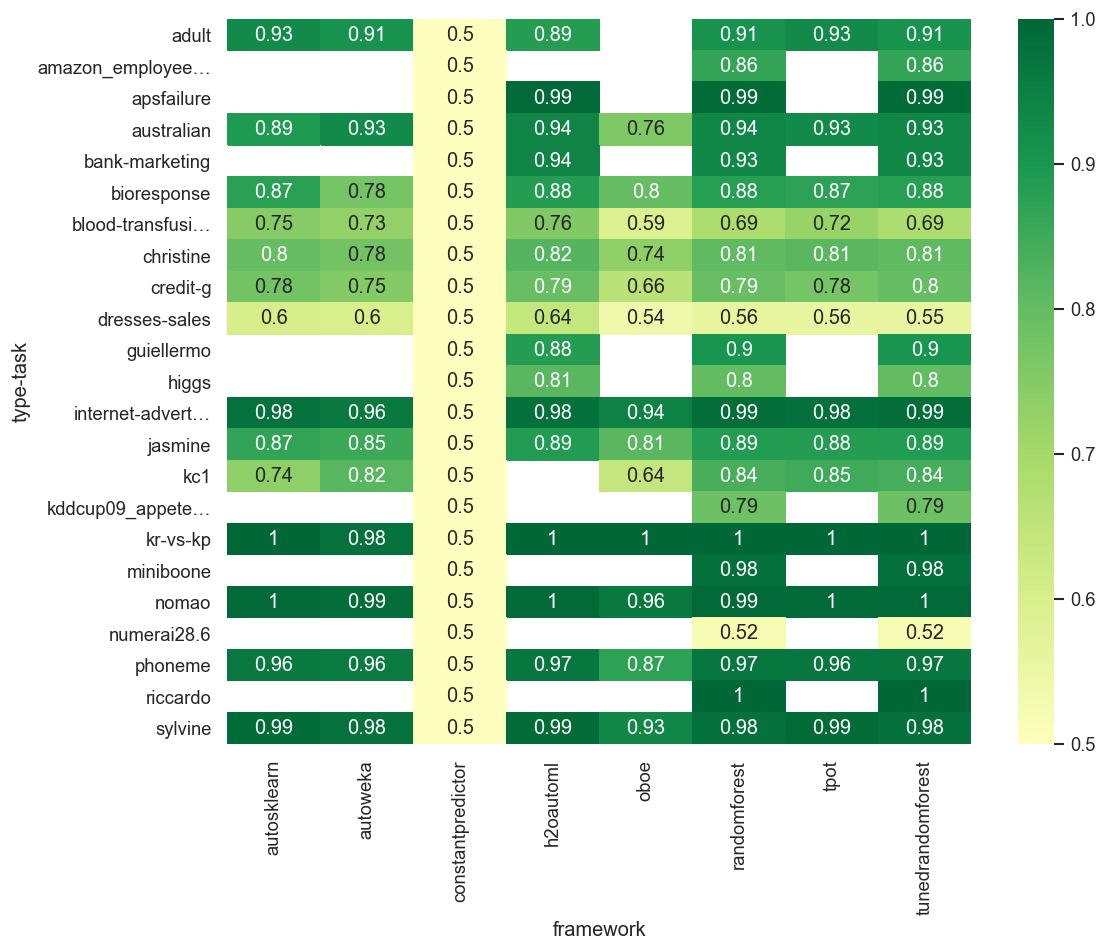

In [17]:
draw_score_heatmap('imp_score',
                   type_filter='binary', 
                   filename="binary_score_heat.png",
                   center=0.5);

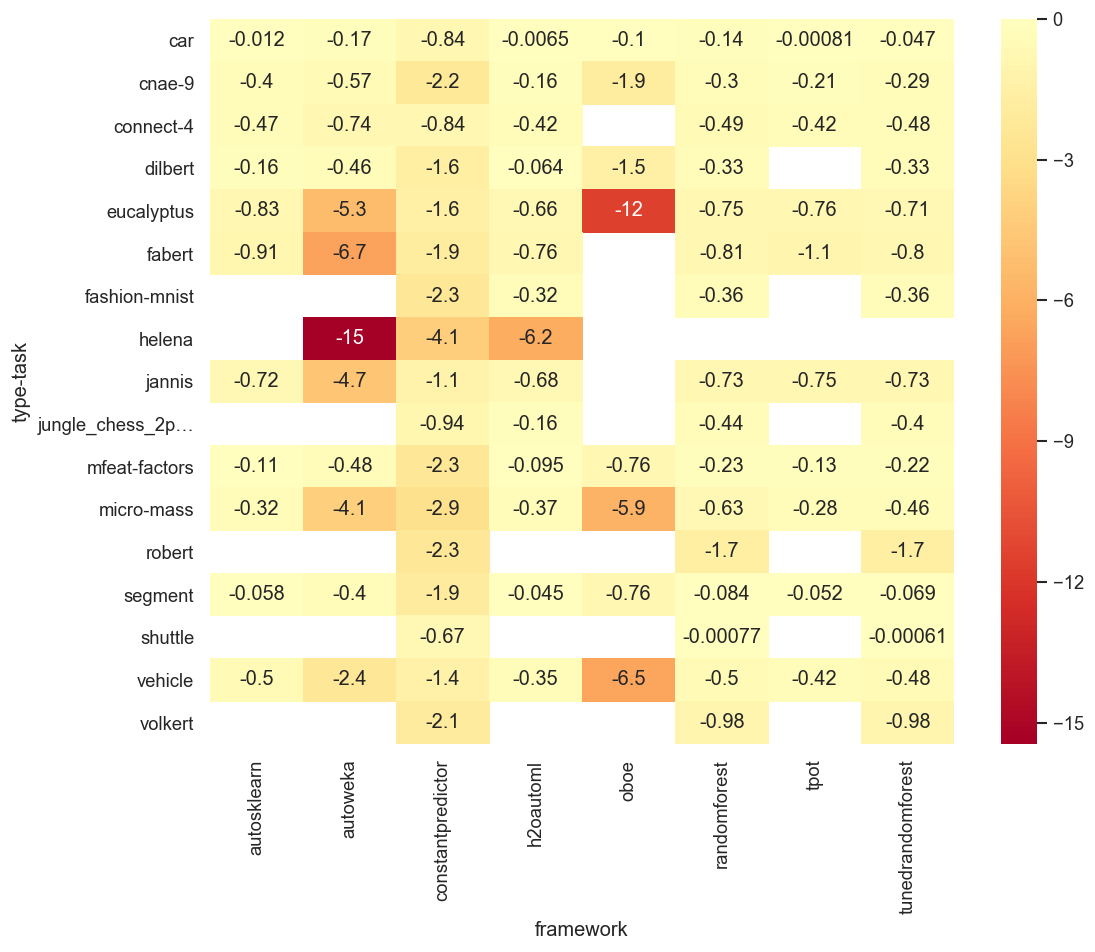

In [18]:
draw_score_heatmap('imp_score', 
                   type_filter='multiclass', 
                   filename="multiclass_score_heat.png",
                   center=0);

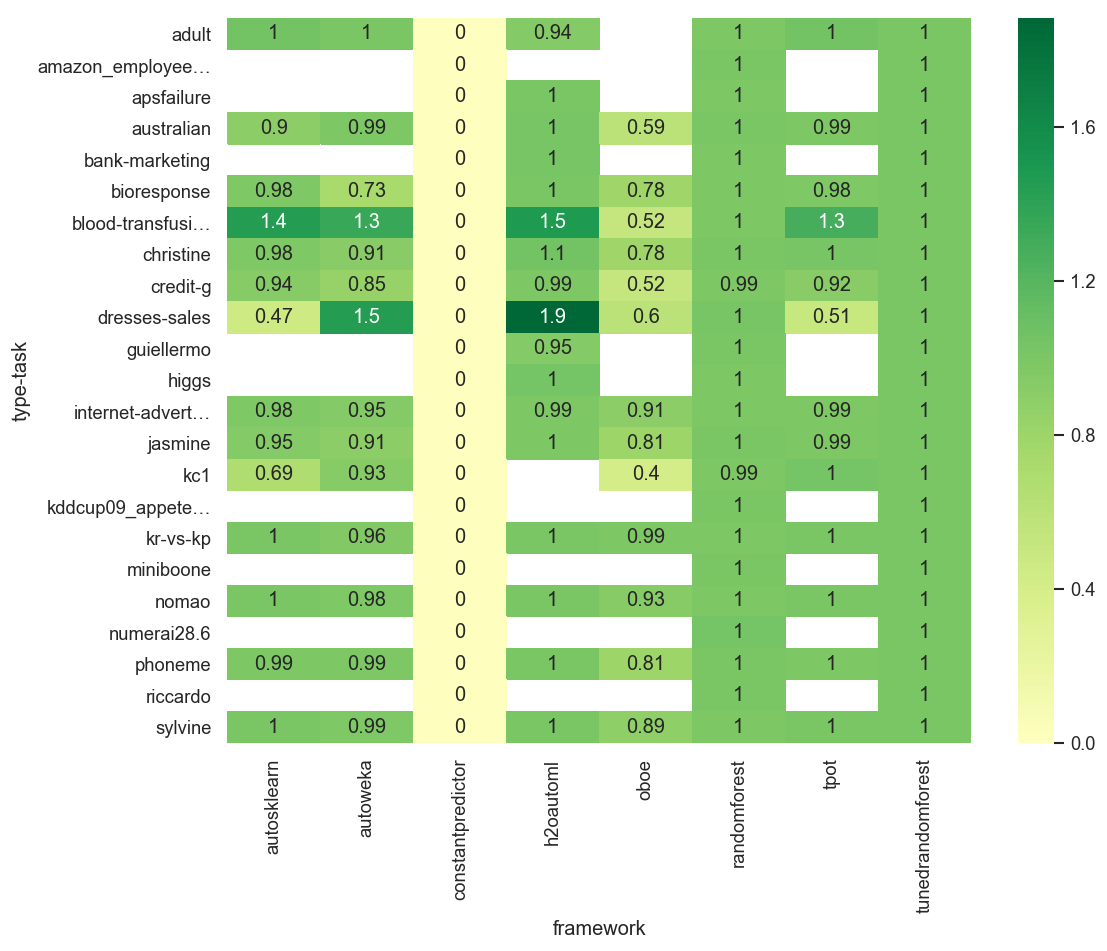

In [19]:
draw_score_heatmap('norm_score', 
                   type_filter='binary', 
                   filename="binary_norm_score_heat.png",
                   center=0);

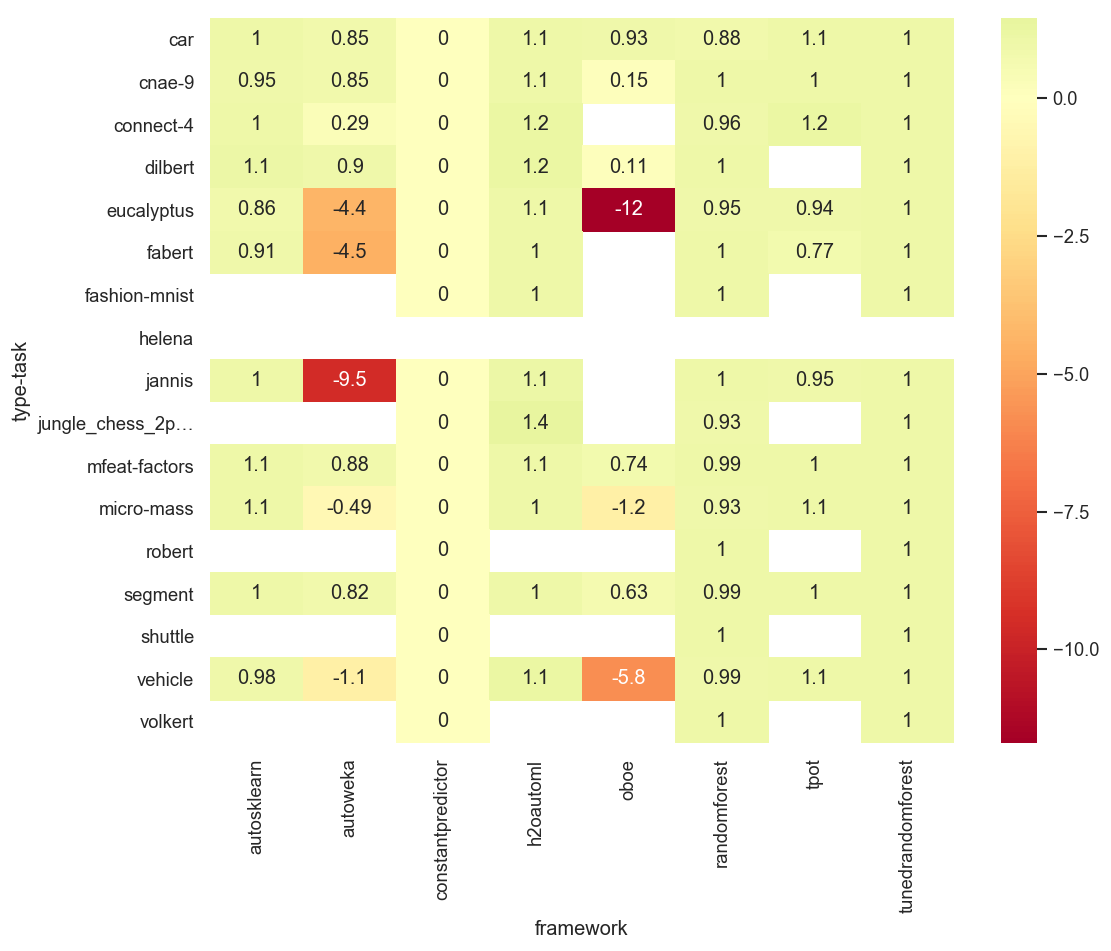

In [20]:
draw_score_heatmap('norm_score', 
                   type_filter='multiclass', 
                   filename="multiclass_norm_score_heat.png",
                   center=0);

### Linear plots

In [21]:
def draw_parallel_coord(df, class_column, x_labels=True, yscale='linear', legend_loc='best'):
    parallel_fig = mp.pyplot.figure(dpi=120, figsize=(10, 6))
    axes = pd.plotting.parallel_coordinates(df, 
                                            class_column=class_column, 
                                            colormap='tab10')
    axes.set_yscale(yscale)
    if x_labels is not None:
        axes.set_xticklabels(x_labels)
    axes.tick_params(axis='x', labelrotation=90) 
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc=legend_loc)
    return parallel_fig


def draw_score_parallel_coord(col, type_filter='all', filename=None, **kwargs):
    df = res_group[col].mean().unstack(['type', 'task'])
    df = df if type_filter == 'all' \
            else df.iloc[:, df.columns.get_loc(type_filter)]
    df.reset_index(inplace=True)
    fig = draw_parallel_coord(df, 
                              'framework',
                              x_labels=task_labels(df.columns.drop('framework')),
                              **kwargs) 
    if filename is not None:
        savefig(fig, filename)
    return fig

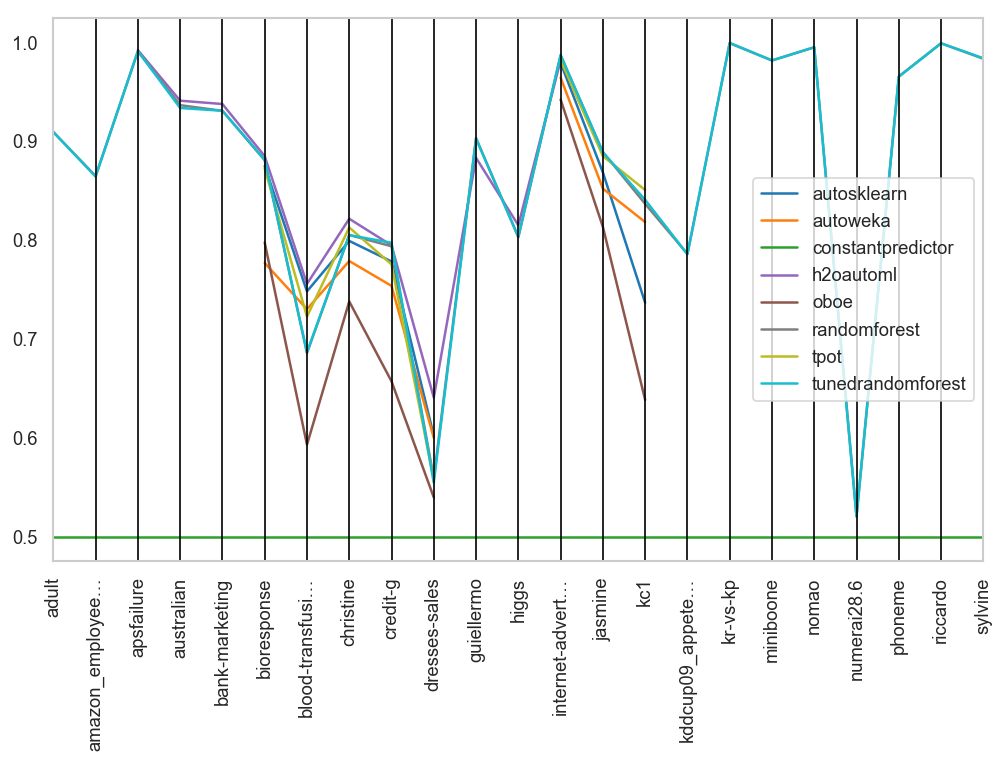

In [22]:
draw_score_parallel_coord('imp_score',
                          type_filter='binary', 
                          filename="binary_score_parallel_ccord.png");

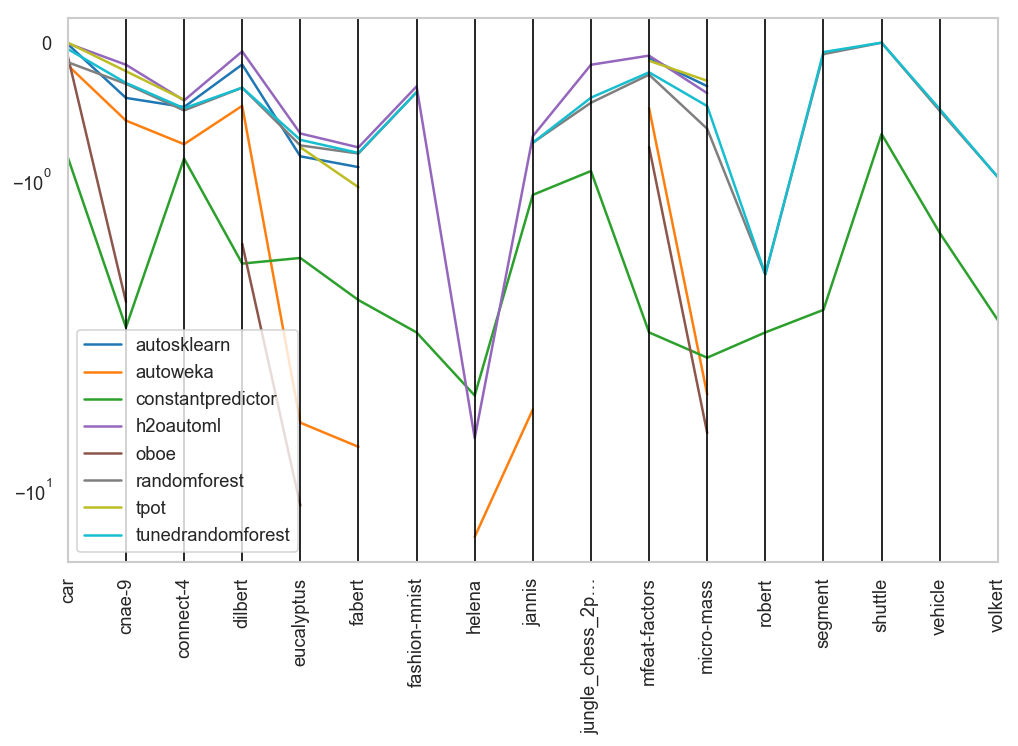

In [23]:
draw_score_parallel_coord('imp_score',
                          type_filter='multiclass',
                          filename="multiclass_score_parallel_ccord.png", 
                          yscale='symlog');

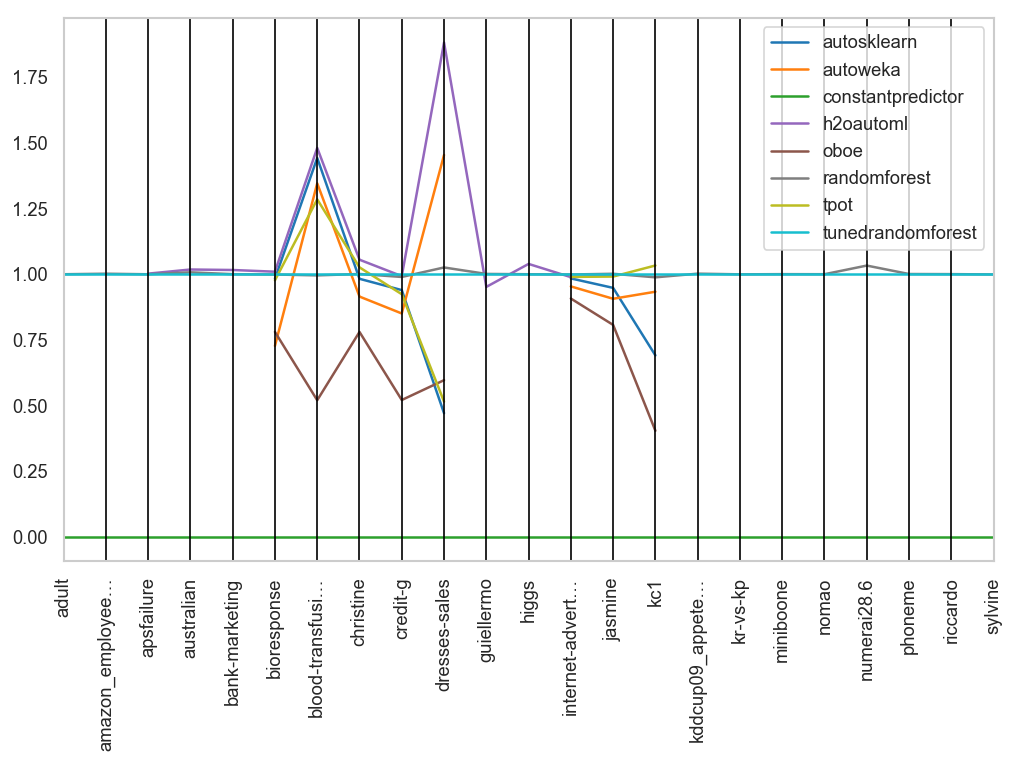

In [24]:
draw_score_parallel_coord('norm_score', 
                          type_filter='binary', 
                          filename="binary_norm_score_parallel_ccord.png");

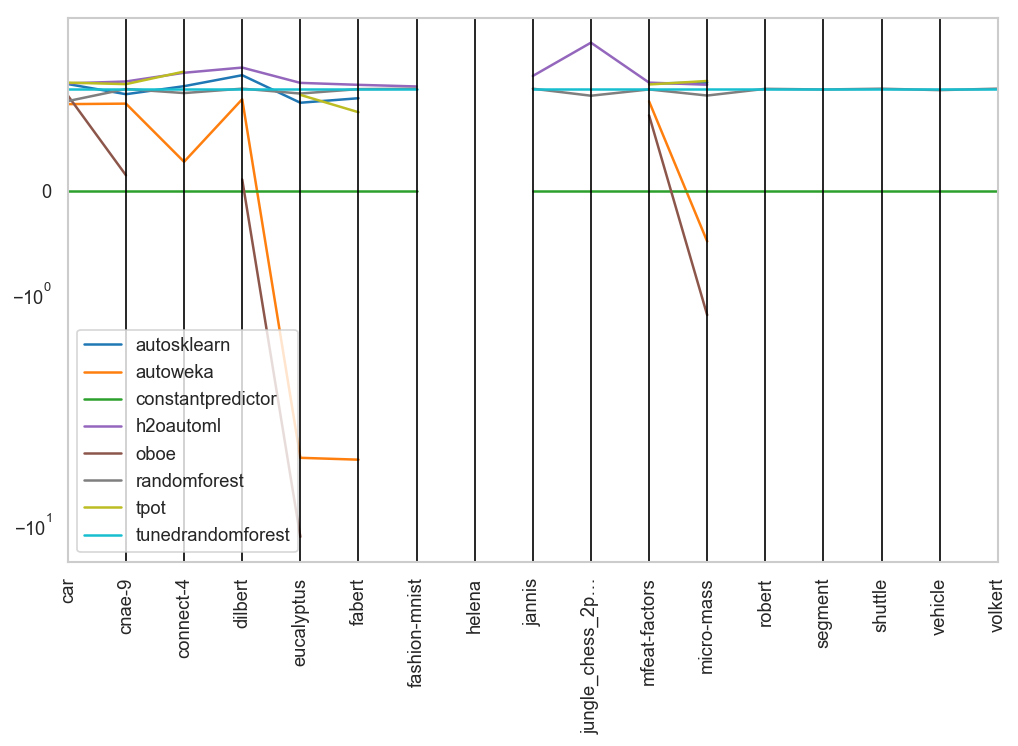

In [25]:
draw_score_parallel_coord('norm_score', 
                          type_filter='multiclass',
                          filename="multiclass_norm_score_parallel_ccord.png", 
                          yscale='symlog');

### Scatterplots

In [26]:
def draw_stripplot(df, x, y, hue, xscale='linear', xbound=None, y_labels=None, legend_loc='best'):
    sb.set(style="whitegrid")
    # Initialize the figure
    strip_fig, axes = mp.pyplot.subplots(dpi=120, figsize=(10, 10))
    axes.set_xscale(xscale)
    if xbound is not None:   
        axes.set_autoscalex_on(False)
        axes.set_xbound(*xbound)
#     axes.invert_xaxis()
    sb.despine(bottom=True, left=True)

    # Show each observation with a scatterplot
    sb.stripplot(x=x, y=y, hue=hue,
                 data=df, dodge=True, jitter=True,
                 alpha=.25, zorder=1)

    # Show the conditional means
    sb.pointplot(x=x, y=y, hue=hue,
                 data=df, dodge=.5, join=False, palette="tab10",
                 markers="d", scale=.75, ci=None)

    if y_labels is not None:
        axes.set_yticklabels(y_labels)
   # Improve the legend 
    handles, labels = axes.get_legend_handles_labels()
    dist = int(len(labels)/2)
    axes.legend(handles[dist:], labels[dist:], title=hue,
                handletextpad=0, columnspacing=1,
                loc=legend_loc, ncol=1, frameon=True)
    return strip_fig


scatterplot_df = all_results.set_index(['type', 'task']).sort_index()

def draw_score_stripplot(col, type_filter='all', filename=None, **kwargs):
    df = scatterplot_df if type_filter == 'all' \
                        else scatterplot_df[scatterplot_df.index.get_loc(type_filter)]
    fig = draw_stripplot(
        df,
        x=col,
        y=df.index,
        hue='framework',
        y_labels=task_labels(df.index.unique()),
        **kwargs
    )
    if filename is not None:
        savefig(fig, filename)
    return fig

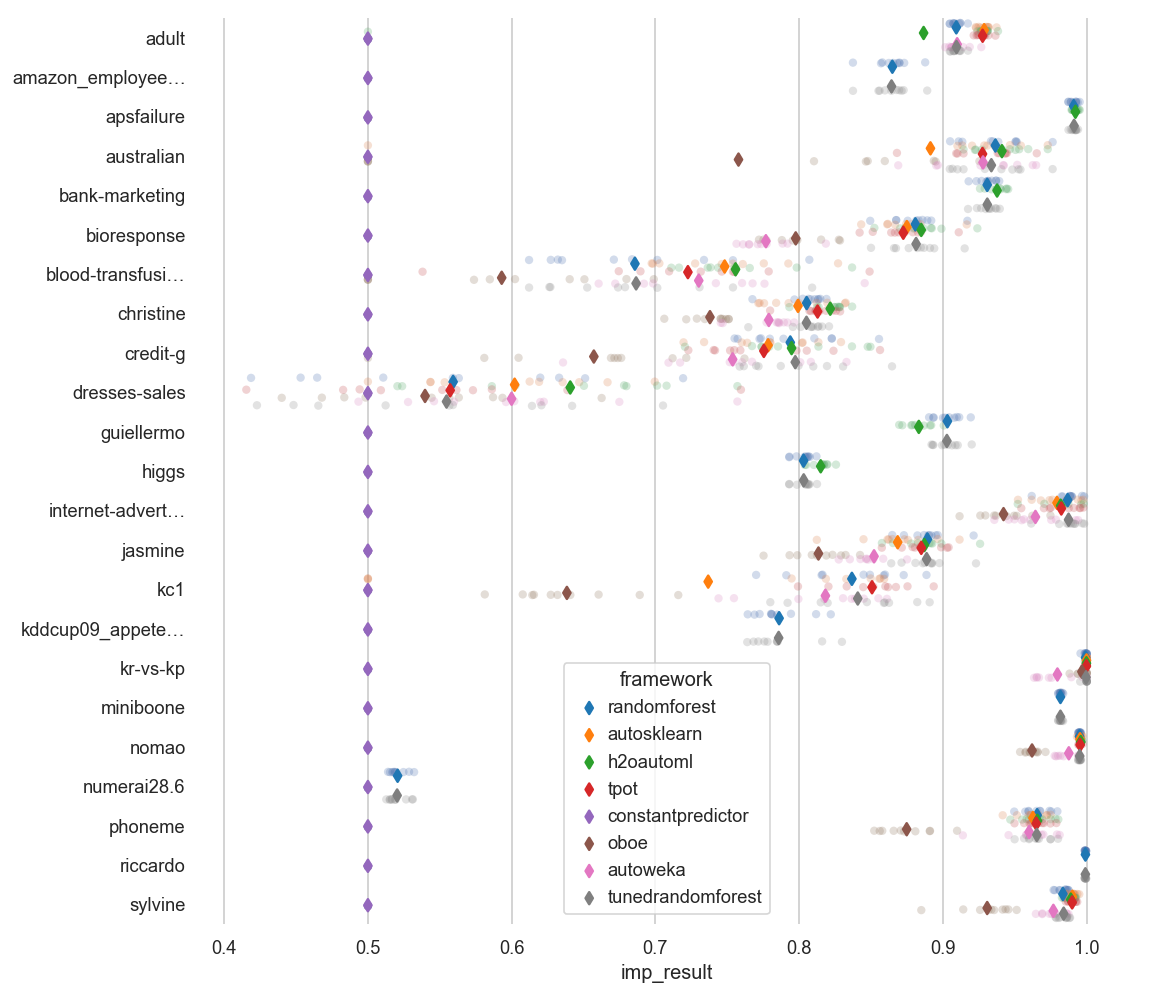

In [27]:
draw_score_stripplot('imp_result', 
                     type_filter='binary', 
                     filename="binary_results_stripplot.png");

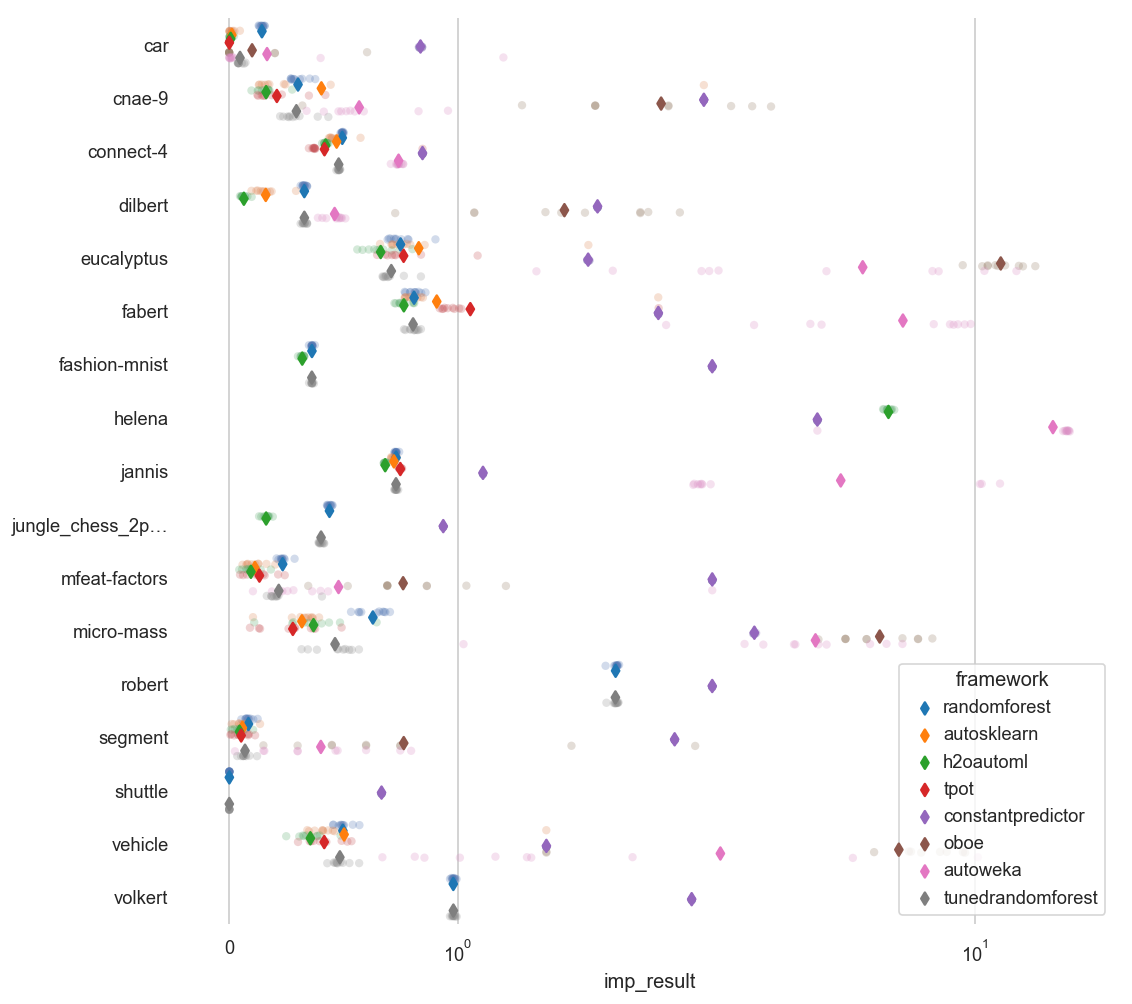

In [28]:
draw_score_stripplot('imp_result',
                     type_filter='multiclass', 
                     filename="multiclass_results_stripplot.png",
#                      xbound=(0,10),
                     xscale='symlog');

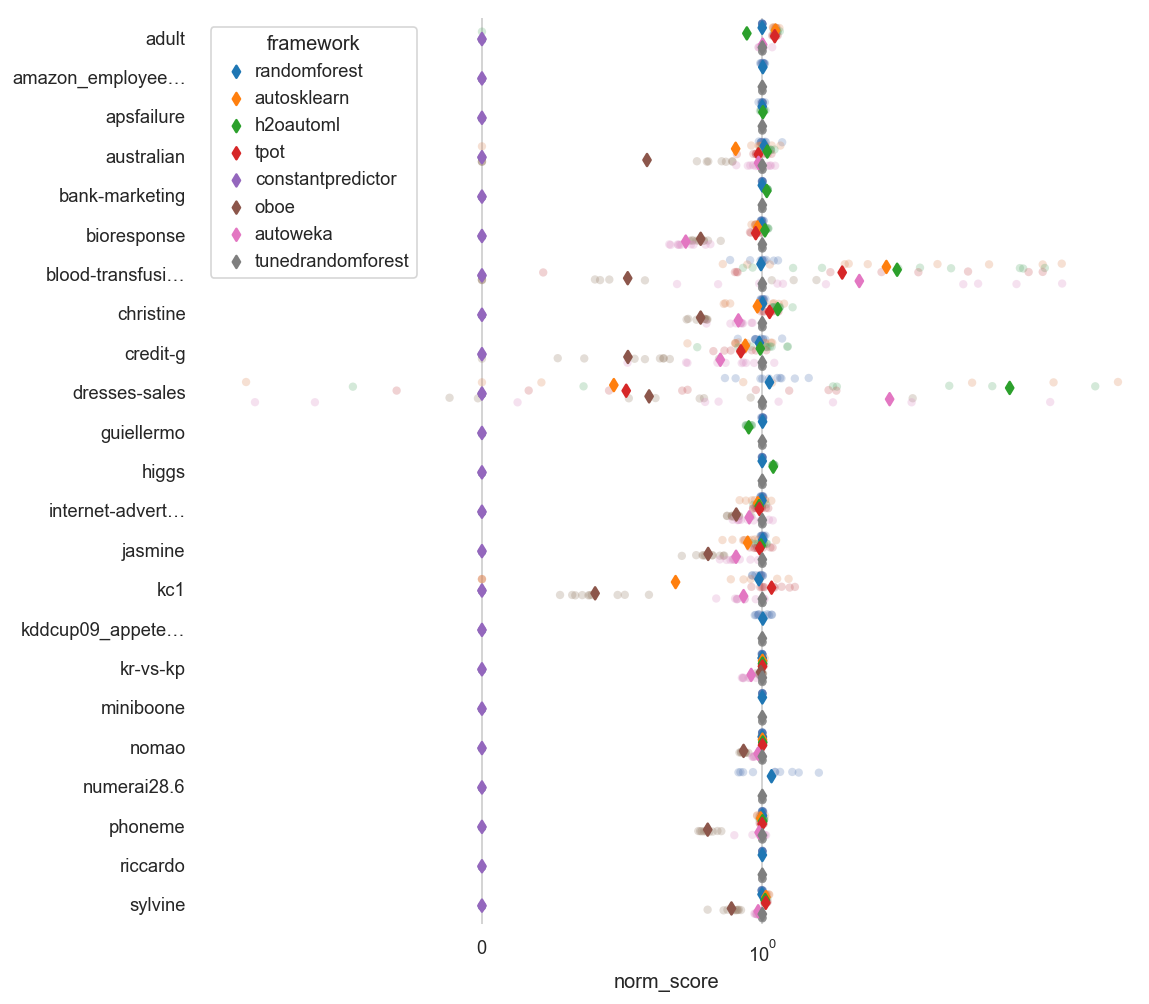

In [29]:
draw_score_stripplot('norm_score', 
                     type_filter='binary', 
                     filename="binary_norm_score_stripplot.png",
                     xbound=(-1, 3),
                     xscale='symlog');

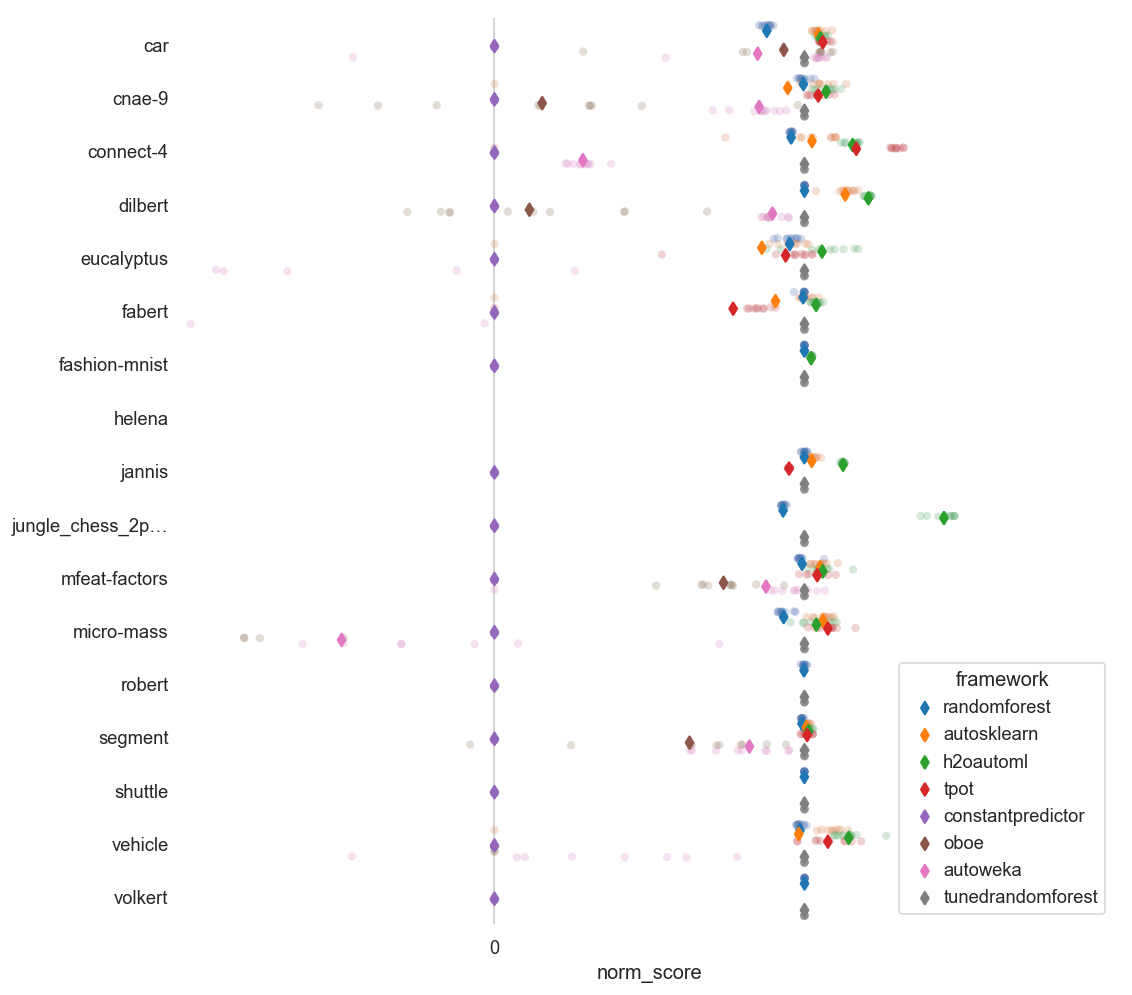

In [30]:
draw_score_stripplot('norm_score', 
                     type_filter='multiclass', 
                     filename="multiclass_norm_score_stripplot.png",
                     xbound=(-1, 2),
                     xscale='symlog');

## Playground

In [31]:
all_results.loc[(all_results.task=='dilbert')&(all_results.framework=='randomforest')];

In [32]:
done.iloc[done.index.get_level_values('framework').isin(['autosklearn', 'h2oautoml', 'tpot'])]\
    .apply(sorted_ints);

In [33]:
failures = all_failed.groupby(['task', 'fold', 'framework'])['info']\
                    .unique();
display(failures)